# Time Domain Science Cases in the Galactic Plane

The purpose of this notebook is to refined the analysis performed in time_domain_science_fields.ipynb.  
The previous notebook identified regions of common science interest from the community proposals without any input from the Design Committee in the form of prioritizing selected regions.  
The goal of this notebook is to introduce the Committee's priority in the form of weighting some regions identified to be of special scientific interest. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import config_utils
import survey_footprints
import regions
import plot_sky_regions
import healpixel_clustering
import healpy as hp
from mw_plot import MWSkyMap, MWSkyMapBokeh
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord, ICRS
from astropy.table import Table, Column
from astropy.io import ascii
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from os import path
%matplotlib inline


# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

# HEALpixel grid resolution
NSIDE = 64
PIXAREA = hp.nside2pixarea(NSIDE, degrees=True)

## Load input data

First we load the simulation parameters for reference.

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

To begin with, we load information about the different science cases from the community - these currently have no priority weighting. 

In [3]:
science_cases = config_utils.read_config(path.join(root_dir, 'config', 'rgps_science_cases.json'))

Science cases requesting time domain observations are identifed in the configurations with a Boolean 'time_domain' key.  
So we can extract the information for just those cases for further analysis. 

In [4]:
time_domain_science = {author: info for author, info in science_cases.items() if info['time_domain']}
authors_list = [x for x in time_domain_science.keys()]
authors_list.sort()

# Note we exclude these science cases as they request very large sky areas that are too large to include in a time domain study
pop_list = ['DAmmando', 'Pascucci', 'Bahramian', 'Navarro']
time_domain_authors = []
for author in authors_list: 
    if author not in pop_list: 
        time_domain_authors.append(author)

To save repeatedly calculating the HEALpixel maps for each science case we can load the pre-calculated maps for the time domain science cases. 

In [5]:
science_regions = regions.load_regions_from_file(sim_config,
                                                         path.join(root_dir, 'config', 'rgps_time_domain_science_regions.json'))

In [6]:
# Collect the regions for all time domain science cases.  Note not all of them may be present; this 
# happens if a science case is marked not ready for use.  This is done if insufficient information has been provided by 
# an author.
time_domain_regions = {} 
for author in time_domain_authors:
    if author in science_regions.keys():
        time_domain_regions[author] = science_regions[author]

Lastly, let's load the preliminary time domain survey regions.

In [7]:
TD_regions = ascii.read(path.join(root_dir, 'time_domain_science', 'selected_tda_candidate_tda_fields_table.txt'))

TD_regions 

<Table length=6>
  ID       l_center      ...          b0                  b1        
int64      float64       ...       float64             float64      
----- ------------------ ... ------------------- -------------------
    0  48.24032919755048 ... -1.4114179705061947  0.3734247027509323
    1 30.918934476251493 ...  1.5130688759139403  2.7634742117946898
    2 28.044595009290774 ... 0.42073947105053183  2.9146797929137933
    3 28.050816657433884 ... -0.4766073328462903 -0.1266892528610955
    4  25.37605755001467 ...  1.4651381451102967  2.7070063210966073
    5  359.7122900035529 ... -0.7800015493729588  0.2670240688620124

## Map of overlapping regions of scientific interest

By combining the HEALpixel maps of the regions of interest for each time domain science case, we can arrive at a "heatmap" of the regions where mutiple science experiments can be done within a limited area.  

To start with, we built this map with NO PRIORITY WEIGHTING given to any specific regions; this is simply those regions that overlap. 

Maximum HEALpixel value = 4.0


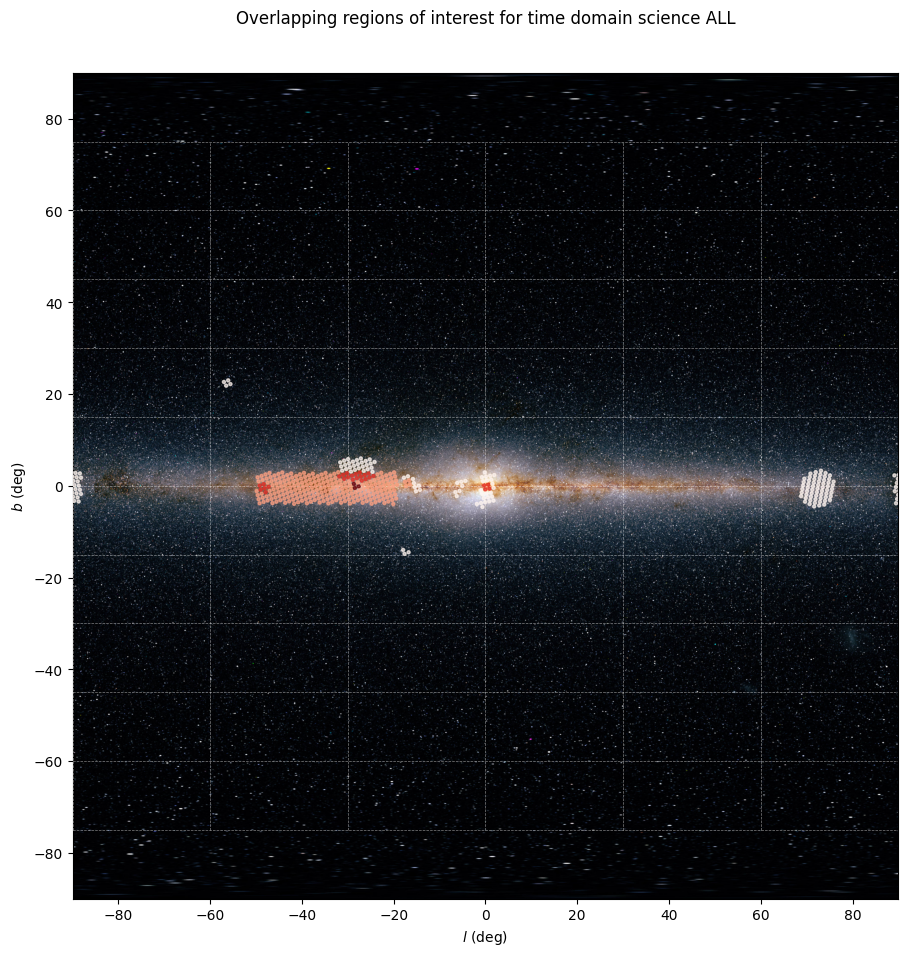

In [8]:
# Compile a list of regions for this optic over all science cases 
region_list = []
region_names = []

for optic in sim_config['OPTICAL_COMPONENTS']: 

    for author, params in time_domain_regions.items():
        if optic in params.keys():

            # Do not duplicate a region if an author has requested it for multiple filters
            for r in params[optic]:
                if r.name not in region_names:
                    region_list.append(r)
                    region_names.append(r.name)

if len(region_list) > 0:
    r_merge = regions.combine_regions(region_list)
    r_merge.optic = 'ALL'
    r_merge.label = 'Overlapping regions of interest for time domain science'

    mw1 = MWSkyMap(grayscale=False, grid='galactic', background='infrared', figsize=(16, 10), 
               center=(0.0*u.deg, 0.0*u.deg), radius=(90.0*u.deg, 90.0*u.deg))
    mw1.title = r_merge.label + ' ' + r_merge.optic
    s = r_merge.pixels_to_skycoords()
    mw1.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=r_merge.region_map[r_merge.pixels], cmap='Reds', s=5, alpha=0.7)
    plt.rcParams.update({'font.size': 22})

    plt.tight_layout()
    plt.savefig(path.join(root_dir, 'time_domain_science', 'tda_all_requested_regions_map.png'))

print('Maximum HEALpixel value = ' + str(r_merge.region_map.max()))

Its informative to look at the sections of the Plane around the select W40/Serpens region due to the large number of potential targets in that area. 

In [9]:
# W40
wforty = SkyCoord('18:31:29', '−02:05:24', frame='icrs', unit=(u.hourangle, u.deg)) 
wforty_gal = wforty.transform_to('galactic')
wforty_gal

<SkyCoord (Galactic): (l, b) in deg
    (28.7906686, 3.48062241)>

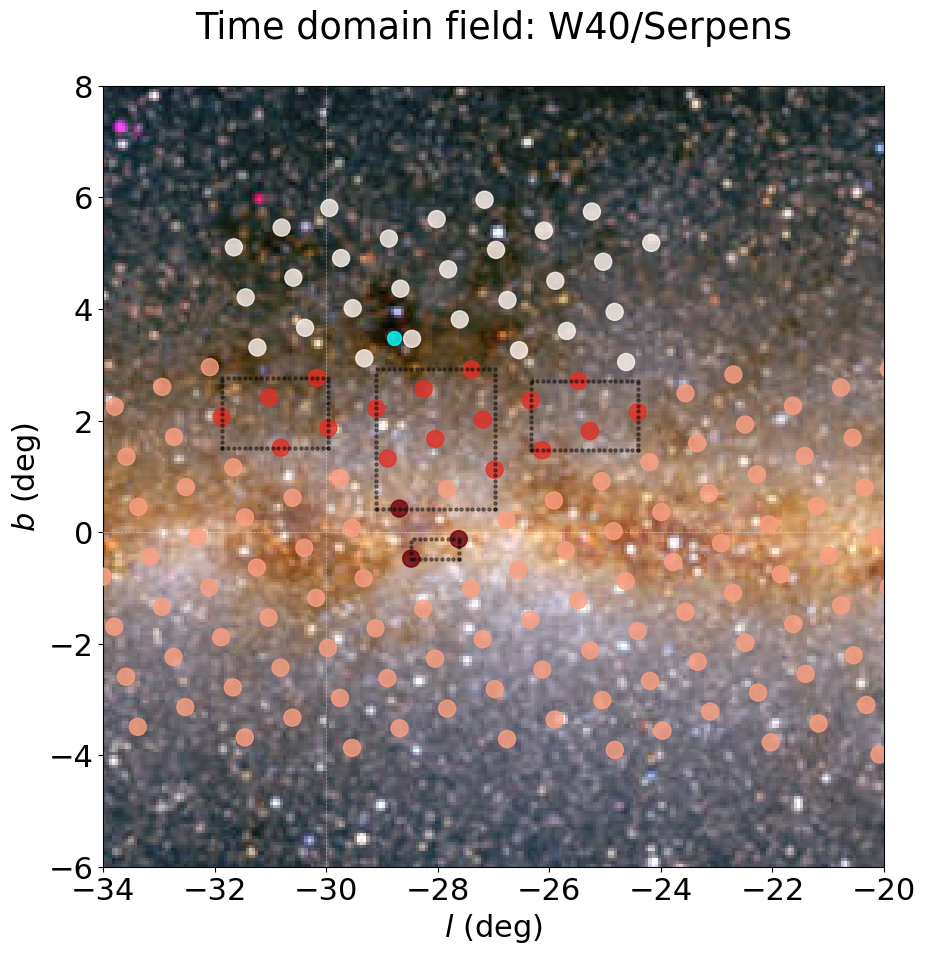

In [12]:
# Close up of W40/Serpens
l_cen = -27.0
b_cen = 1.0

mw3 = MWSkyMap(grayscale=False, grid='galactic', background='infrared', figsize=(16, 10), 
               center=(l_cen*u.deg, b_cen*u.deg), radius=(7.0*u.deg, 7.0*u.deg))
mw3.title = 'Time domain field: W40/Serpens'

# Plot HEALpixel map of requested regions, shaded according to pixel priority
s = r_merge.pixels_to_skycoords()
mw3.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=r_merge.pixel_priority[r_merge.pixels], cmap='Reds', s=150, alpha=0.8)

# Plot outlines of time domain fields
for i in range(1,5,1):
    r = TD_regions[i]
    outline = {
        'l': [float(r['l0']), float(r['l1'])],
        'b': [float(r['b0']), float(r['b1'])]
    }
    plot_sky_regions.plot_outline(mw3, outline, outline_color='black')

# Plot location of W40 
mw3.scatter(wforty.ra.deg * u.deg, wforty.dec.deg * u.deg, c='cyan', s=100, alpha=0.8)

plt.rcParams.update({'font.size': 22})
plt.tight_layout()
plt.savefig(path.join(root_dir, 'time_domain_science', 'w40_serpens_out_of_area_demo.png'))

In the plot above, the dots shaded white to red mark HEALpixel centroids where the color indicates the number of science cases requesting that specific HEALpixel, with red being the highest.  

The preliminary time-domain survey regions (outlined in black) were determined based purely on the popularity of a given HEALpixel, clustered into groups.  

The issue with this is that the Design Committee have identified some targets that are scientifically particularly valuable, but which were the subject of only one (albeit highly weighted) science pitch or white paper.  An example of this is that W40 - marked as a purple dot - was requested as part of a larger region which extends up to b~5 deg.  This can be seen in the plot above represented as as a  lightly-shaded region.  Since this was requested infrequently, W40 was excluded from the final survey region.  

## Prioritizing regions for time domain science

To overcome this issue, the Design Committee can assign a higher priority to selected regions.  

As an example, here we increase the priority assigned to the W40 region from Roberta Paladini's proposal.  

In [13]:
r = time_domain_regions['Paladini2']['F213'][0]
r.pixel_priority[r.pixels] += 3.0
time_domain_regions['Paladini2']['F213'][0] = r

Now we can re-build the map of combined regions of interest, with the priority taken into account. 

In [14]:
# Compile a list of regions for this optic over all science cases 
region_list = []
region_names = []

for optic in sim_config['OPTICAL_COMPONENTS']: 

    for author, params in time_domain_regions.items():
        if optic in params.keys():

            # Do not duplicate a region if an author has requested it for multiple filters
            for r in params[optic]:
                if r.name not in region_names:
                    region_list.append(r)
                    region_names.append(r.name)

if len(region_list) > 0:
    r_merge_priority = regions.combine_regions(region_list)
    r_merge_priority.optic = 'ALL'
    r_merge_priority.label = 'Prioritized regions of interest for time domain science'

print('Maximum HEALpixel value = ' + str(r_merge_priority.region_map.max()))

Maximum HEALpixel value = 4.0


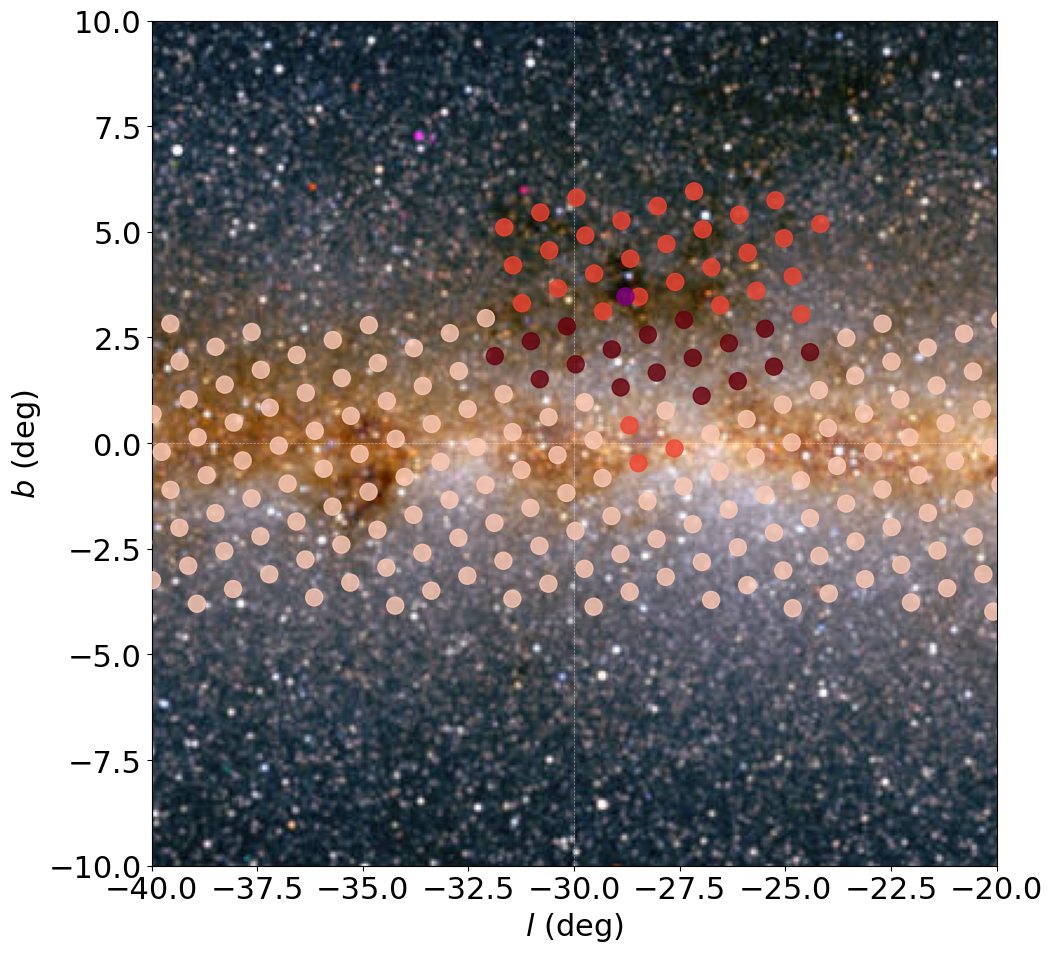

In [15]:
# Close up of W40/Serpens
l_cen = -30.0
b_cen = 0.0

mw1 = MWSkyMap(grayscale=False, grid='galactic', background='infrared', figsize=(16, 10), 
           center=(l_cen*u.deg, b_cen*u.deg), radius=(10.0*u.deg, 10.0*u.deg))

s = r_merge.pixels_to_skycoords()
mw1.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=r_merge_priority.pixel_priority[r_merge_priority.pixels], cmap='Reds', s=150, alpha=0.8)

# Plot location of W40 
mw1.scatter(wforty.ra.deg * u.deg, wforty.dec.deg * u.deg, c='purple', s=150, alpha=0.8)

plt.rcParams.update({'font.size': 22})
plt.tight_layout()

## Identifying Time Domain Fields with Prioritized regions

Using this combined region with adjusted priorities, we can repeat our clustering algorithm to identify the revised high-priority regions. 

In [29]:
# Select HEALpixels with a priority greater than the selection threshold 
candidate_regions = healpixel_clustering.find_priority_pixels(r_merge_priority, threshold=4.0)

# Identify clusters of pixels.  Note this function eliminates any clusters that are unfeasibly large
candidate_regions = healpixel_clustering.cluster_pixels(candidate_regions)

# Select isolated clusters of pixels as our final regions of interest
TD_regions = healpixel_clustering.identify_clusters(candidate_regions, max_sep=1.0)

TD_regions

 ID      l_center            b_center              l0                 l1                  b0                  b1        
--- ------------------ ------------------- ------------------ ------------------ ------------------- -------------------
  0  30.58896876678878   4.560508910950938 29.525885424728113 31.655760274583837  3.3092508944047623    5.81019812956122
  1 30.918934476251493  2.1385699699338314 29.961687389451274   31.8769619838468  1.5130688759139403  2.7634742117946898
  2  28.03148757805926   4.537438471515029 26.750720430764684  29.31730876200194  3.1147796950254167   5.957830613791004
  3 28.044595009290774  1.6679966363910095   26.9820729303582 29.108464857799547 0.42073947105053183  2.9146797929137933
  4  25.35698424850394   4.504115892350195  24.17378001341685 26.544236855123337   3.261071985932059  5.7452404163351325
  5 28.050816657433884 -0.3016566470630278 27.624388519213877  28.47723108449249 -0.4766073328462903 -0.1266892528610955
  6  25.37591361051033  2.257223

<Table length=7>
  ID       l_center      ...          b0                  b1        
int64      float64       ...       float64             float64      
----- ------------------ ... ------------------- -------------------
    0  30.58896876678878 ...  3.3092508944047623    5.81019812956122
    1 30.918934476251493 ...  1.5130688759139403  2.7634742117946898
    2  28.03148757805926 ...  3.1147796950254167   5.957830613791004
    3 28.044595009290774 ... 0.42073947105053183  2.9146797929137933
    4  25.35698424850394 ...   3.261071985932059  5.7452404163351325
    5 28.050816657433884 ... -0.4766073328462903 -0.1266892528610955
    6  25.37591361051033 ...  1.4651381451102967  3.0486764447677466

Plot these selected regions for easy reference.

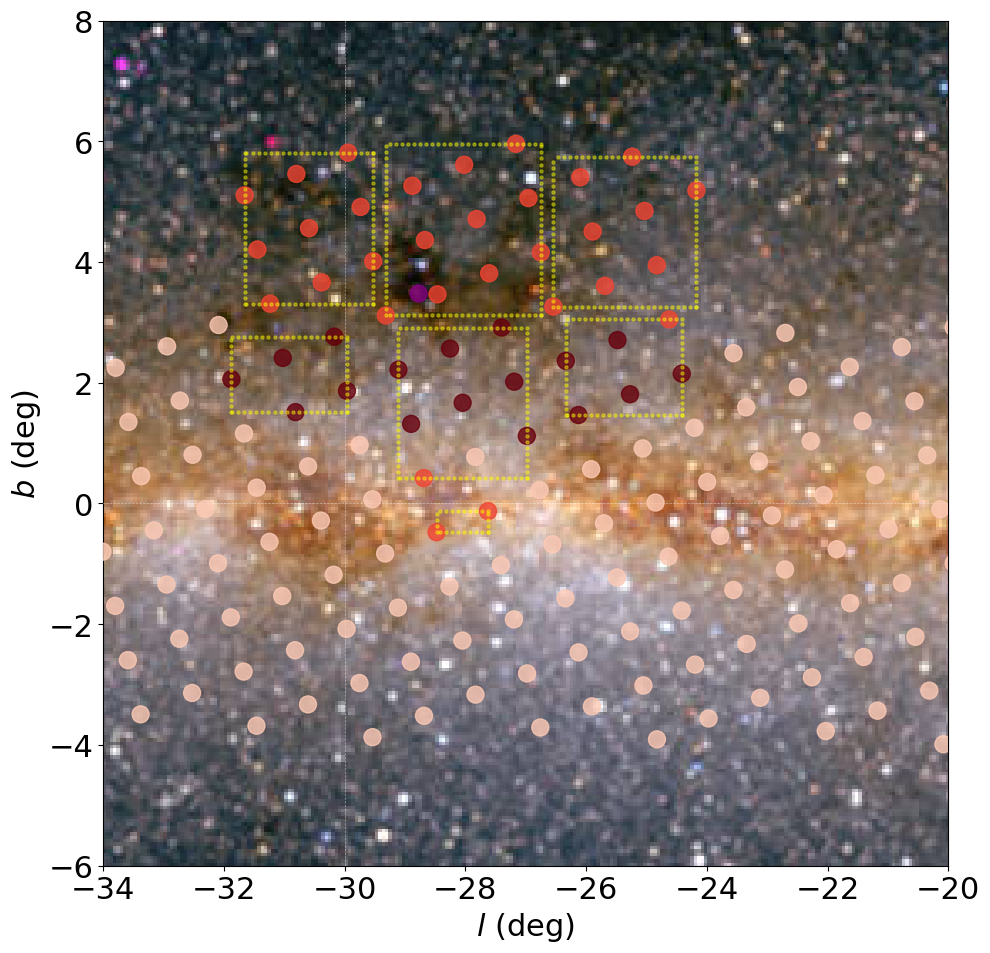

In [30]:
# Plot the selected TDA regions 
l_cen = -27.0
b_cen = 1.0

mw2 = MWSkyMap(grayscale=False, grid='galactic', background='infrared', figsize=(16, 10), 
           center=(l_cen*u.deg, b_cen*u.deg), radius=(7.0*u.deg, 7.0*u.deg))
proj = HEALPix(nside=64, order='ring', frame='icrs')

s = r_merge.pixels_to_skycoords()
mw2.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=r_merge_priority.pixel_priority[r_merge_priority.pixels], cmap='Reds', s=150, alpha=0.8)

# Plot location of W40 
mw2.scatter(wforty.ra.deg * u.deg, wforty.dec.deg * u.deg, c='purple', s=150, alpha=0.8)

for r in TD_regions:
    outline = {
        'l': [float(r['l0']), float(r['l1'])],
        'b': [float(r['b0']), float(r['b1'])]
    }
    #print(outline)
    plot_sky_regions.plot_outline(mw2, outline, outline_color='yellow')

plt.rcParams.update({'font.size': 22})

plt.tight_layout()
plt.savefig(path.join(root_dir, 'time_domain_science', 'w40_serpens_out_of_area_demo2.png'))

The plot above demonstrates how adjusting the priorities of a specific science case can refined the resulting science regions of interest.

## Refining the field boundaries

The pixel based approach tends to result in closely neighboring, subdivided regions.  The algorithm can be allowed to "grow" the regions to merge cases like this, but this tends to result in very large regions, that will require considerable time to survey, especially for time domain science.  

So an interactive approach to identify the finalized field boundaries is the most appropriate, based on the algorithm's output.  

In [53]:
# Refined boundaries for W40/Serpens region
serpens = [
    {
        'l': [24.17378001341685, 31.8769619838468],
        'b': [1.4651381451102967, 5.95783061379100]
    },
    {
        'l': [27.0, 29.1],
        'b': [-0.4766073328462903, 1.5130688759139403]
    },
#    {
#        'l': [26.9820729303582, 29.108464857799547],
#        'b': [-0.4766073328462903, 1.4651381451102967]
#    },
]

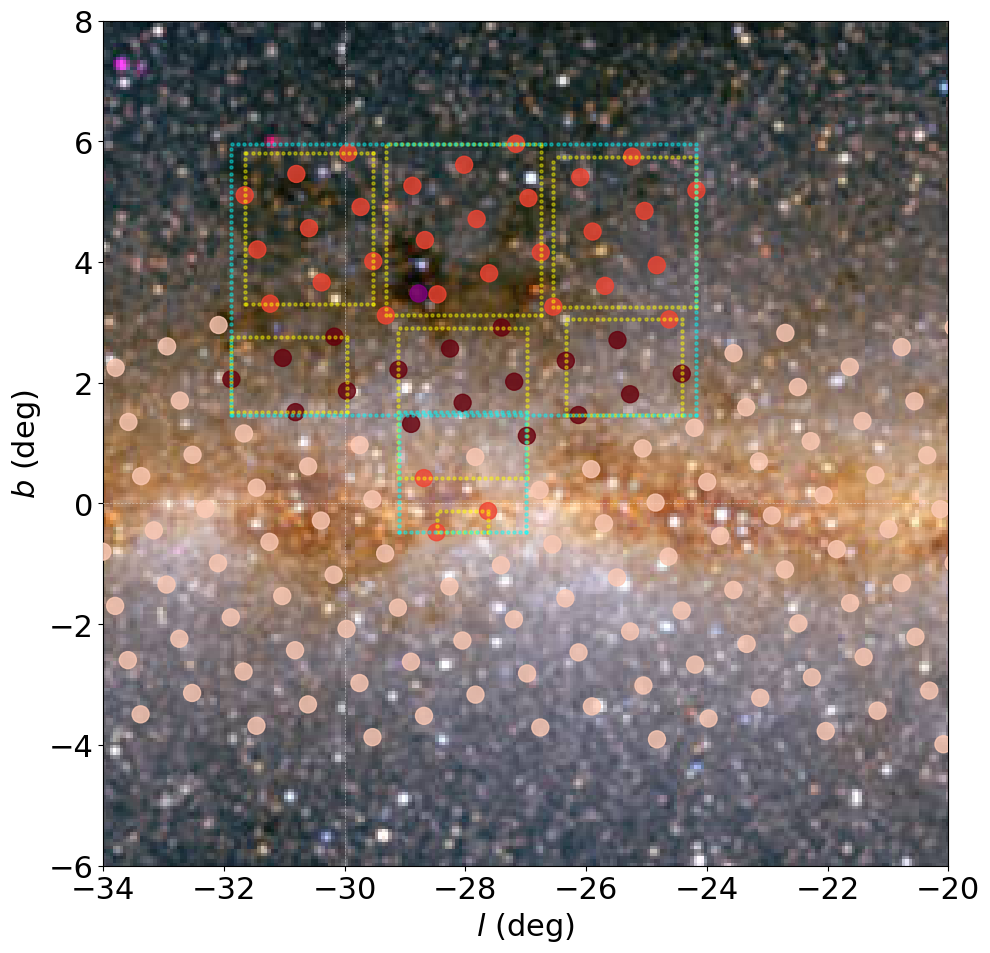

In [54]:
# Plot the selected TDA regions 
l_cen = -27.0
b_cen = 1.0

mw2 = MWSkyMap(grayscale=False, grid='galactic', background='infrared', figsize=(16, 10), 
           center=(l_cen*u.deg, b_cen*u.deg), radius=(7.0*u.deg, 7.0*u.deg))
proj = HEALPix(nside=64, order='ring', frame='icrs')

s = r_merge.pixels_to_skycoords()
mw2.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=r_merge_priority.pixel_priority[r_merge_priority.pixels], cmap='Reds', s=150, alpha=0.8)

# Plot location of W40 
mw2.scatter(wforty.ra.deg * u.deg, wforty.dec.deg * u.deg, c='purple', s=150, alpha=0.8)

for r in TD_regions:
    outline = {
        'l': [float(r['l0']), float(r['l1'])],
        'b': [float(r['b0']), float(r['b1'])]
    }
    plot_sky_regions.plot_outline(mw2, outline, outline_color='yellow')

# Plot refined boundary
for outline in serpens:
    plot_sky_regions.plot_outline(mw2, outline, outline_color='cyan')

plt.rcParams.update({'font.size': 22})

plt.tight_layout()
plt.savefig(path.join(root_dir, 'time_domain_science', 'w40_serpens_field.png'))